In this notebook - I want to build a classifier to distinguish cats and dogs from a dataset of images.  
at the end of it, we will enter a picture of my own dog Zoey - and see if it classified her correctly.
The dataset below has two folders - Cats and Dogs - each with images of the respective class.  
These images have various shapes and sizes and the Dogs and Cats appear in all sorts of poses and positions around the images

you can see the dataset here

https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset/data

the fun thing is that you can have these folders with the images inside and let the folder structure tell you the label..
so the dog folder - has pictures of dogs - so with a little bit of code we can use this to our advantage.

so pretty much we are given two folders, each has images of each cats and dogs, we want to first count how many we have, then create subdirectories for training and testing 80%/20% split - we start with loading the images, counting them , creating the folders, then splitting them to training and testing as well as vizualising them.

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML, Image as IPImage
from io import BytesIO
import random 
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
 
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

 
out = widgets.Output()
display(out)

def on_upload_change(change):
    with out: 
        clear_output(wait=True)
         
        title = "This is Zoey <3 - she's now 10, shes is all American Red Nose Pitbull"
         
        items = uploader.value
         
        if isinstance(items, tuple):
            items = list(items)
             
        if isinstance(items, dict):
            for file_info in items.values(): 
                image_data = BytesIO(file_info['content'])
                image_data.seek(0)
                img_bytes = image_data.read()
                 
                display(HTML(f"<h3>{title}</h3>"))
                display(IPImage(data=img_bytes))
                 
        elif isinstance(items, list):
            for item in items:
                # If the item is a dict, handle accordingly
                if isinstance(item, dict):
                    image_data = BytesIO(item['content'])
                    image_data.seek(0)
                    img_bytes = image_data.read()
                    display(HTML(f"<h3>{title}</h3>"))
                    display(IPImage(data=img_bytes))
                else:
                    image_data = BytesIO(item.content)
                    image_data.seek(0)
                    img_bytes = image_data.read()
                    display(HTML(f"<h3>{title}</h3>"))
                    display(IPImage(data=img_bytes))
 
uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [2]:
import os 
import shutil

random.seed(42)
 
original_base = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
original_dogs_dir = os.path.join(original_base, 'Dog')
original_cats_dir = os.path.join(original_base, 'Cat')
 
BASE_DIR = '/tf/cats_and_dogs_filtered'
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
 
for d in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    os.makedirs(d, exist_ok=True)

 
def count_images(directory, image_extensions=('.jpg', '.jpeg', '.png')):
    count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                count += 1
    return count

original_dog_count = count_images(original_dogs_dir)
original_cat_count = count_images(original_cats_dir)
print("Original number of Dog images:", original_dog_count)
print("Original number of Cat images:", original_cat_count)

def split_and_copy(src_dir, train_dest, validation_dest, train_ratio=0.8, image_extensions=('.jpg', '.jpeg', '.png')):
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(image_extensions)]
    random.shuffle(files)
    split_index = int(len(files) * train_ratio)
    train_files = files[:split_index]
    validation_files = files[split_index:]
    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dest, f))
    for f in validation_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(validation_dest, f))
    return len(train_files), len(validation_files)

dog_train_count, dog_validation_count = split_and_copy(original_dogs_dir, train_dogs_dir, validation_dogs_dir)
cat_train_count, cat_validation_count = split_and_copy(original_cats_dir, train_cats_dir, validation_cats_dir)

print("\nAfter splitting:")
print("Dog images - Train:", dog_train_count, "Validation:", dog_validation_count)
print("Cat images - Train:", cat_train_count, "Validation:", cat_validation_count)

Original number of Dog images: 12499
Original number of Cat images: 12499

After splitting:
Dog images - Train: 9999 Validation: 2500
Cat images - Train: 9999 Validation: 2500


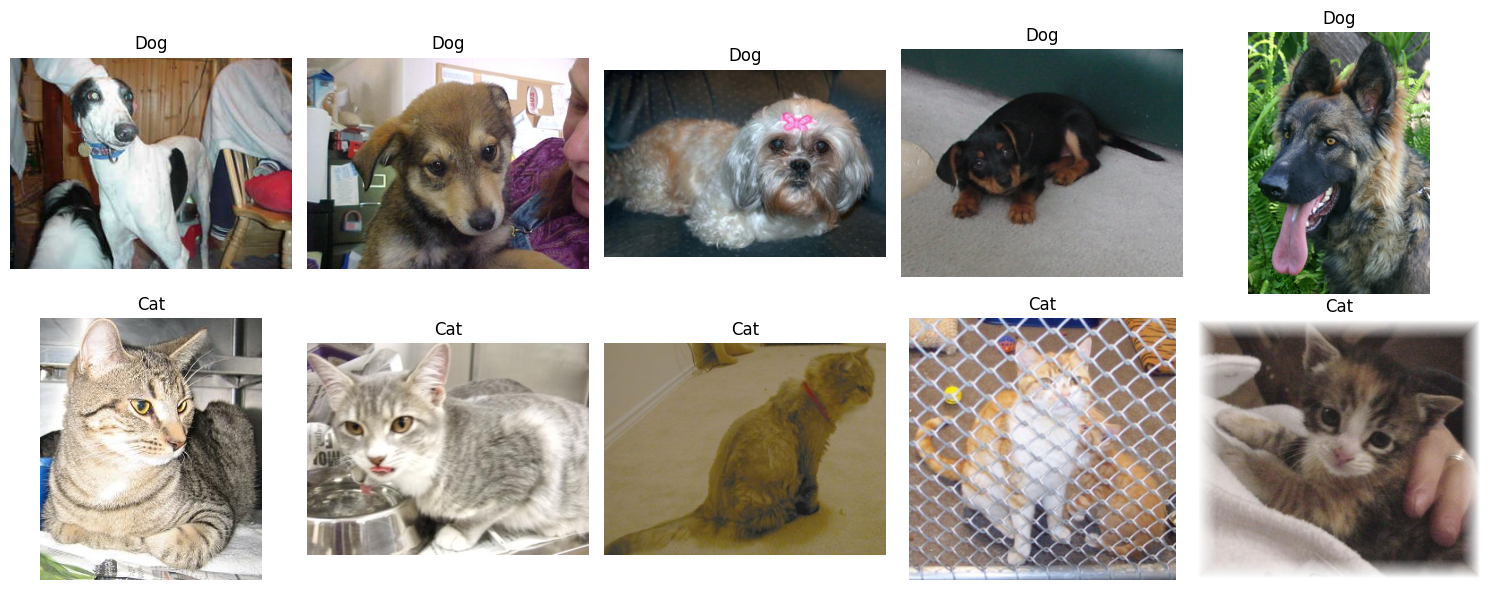

In [3]:
import matplotlib.image as mpimg
random.seed(42) 
 
dog_fnames = os.listdir(train_dogs_dir)
cat_fnames = os.listdir(train_cats_dir)
 
dog_samples = random.sample(dog_fnames, 5) if len(dog_fnames) >= 5 else dog_fnames
cat_samples = random.sample(cat_fnames, 5) if len(cat_fnames) >= 5 else cat_fnames
 
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
 
for i, fname in enumerate(dog_samples):
    img_path = os.path.join(train_dogs_dir, fname)
    img = mpimg.imread(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title("Dog")
 
for i, fname in enumerate(cat_samples):
    img_path = os.path.join(train_cats_dir, fname)
    img = mpimg.imread(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("Cat")

plt.tight_layout()
plt.show()


In [4]:
# look for currupted images and remove them
def get_num_channels(image_path):
    try:
        with Image.open(image_path) as img:
            return len(img.getbands())
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None

def remove_nonstandard_images(directory, valid_channels=(1, 3, 4)):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        channels = get_num_channels(file_path)
        if channels is None or channels not in valid_channels:
            print(f"Removing {file_path} (channels={channels})")
            os.remove(file_path)

remove_nonstandard_images(train_cats_dir)
remove_nonstandard_images(train_dogs_dir)
remove_nonstandard_images(validation_cats_dir)
remove_nonstandard_images(validation_dogs_dir)
 
def tf_is_valid_image(filename):
    try:
        img_data = tf.io.read_file(filename)
        _ = tf.image.decode_jpeg(img_data, channels=3)
        return True
    except Exception as e:
        print(f"Corrupted image {filename}: {e}")
        return False

def clean_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if not tf_is_valid_image(file_path):
            print(f"Removing {file_path} due to TensorFlow decoding error")
            os.remove(file_path)

for d in [train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir]:
    clean_directory(d)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted image /tf/cats_and_dogs_filtered/train/cats/6900.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Removing /tf/cats_and_dogs_filtered/train/cats/6900.jpg due to TensorFlow decoding error
Corrupted image /tf/cats_and_dogs_filtered/train/cats/6768.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Removing /tf/cats_and_dogs_filtered/train/cats/6768.jpg due to TensorFlow decoding error
Corrupted image /tf/cats_and_dogs_filtered/train/cats/3153.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: Dec

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"5 files in cats subdir: {train_cat_fnames[:5]}")
print(f"5 files in dogs subdir: {train_dog_fnames[:5]}")
print(f"Total training cat images: {len(os.listdir(train_cats_dir))}")
print(f"Total training dog images: {len(os.listdir(train_dogs_dir))}")
print(f"Total validation cat images: {len(os.listdir(validation_cats_dir))}")
print(f"Total validation dog images: {len(os.listdir(validation_dogs_dir))}")

5 files in cats subdir: ['10435.jpg', '6790.jpg', '4644.jpg', '1835.jpg', '8962.jpg']
5 files in dogs subdir: ['6790.jpg', '4644.jpg', '1835.jpg', '1102.jpg', '8962.jpg']
Total training cat images: 9944
Total training dog images: 9911
Total validation cat images: 2483
Total validation dog images: 2486


* [cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stores elements in memory as you use them so it will be faster to retrieve if you need them again
* [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), as the name suggests, shuffles the dataset randomly. A `buffer_size` of 1000 means it will first select a sample from the first 1,000 elements, then keep filling this buffer until all elements have been selected.
* [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) gets elements while the model is training so it's faster to feed in new data when the current training step is finished. A `buffer_size` set to `tf.data.AUTOTUNE` dynamically sets the number of elements to prefetch during runtime.

In [6]:
import os
import tensorflow as tf
from PIL import ImageFile
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="PIL.TiffImagePlugin")
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call")

ImageFile.LOAD_TRUNCATED_IMAGES = True 

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
)

SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

# .2 relates to random amount up to that value - depending on roation or zoom 
# fill mode parameter tells the model how to fill in any pixels that might have been lost by the operations. 
# For example, when you move the image to the right, there might just be something filling in the pixels 
# on the left hand side. I'm just going to stick with the nearest here, 
# which uses neighbors of that pixel to try to keep uniformity.

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2 , fill_mode = 'nearest'), 
    tf.keras.layers.RandomTranslation(0.2 , 0.2 , fill_mode = 'nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode = 'nearest')
])
 
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    data_augmentation,                    # Augment images during training
    tf.keras.layers.Rescaling(1./255),    # Normalize pixel values
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.summary()
 
model.compile( optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] )
 
history = model.fit( train_dataset_final, epochs=15, validation_data=validation_dataset_final, verbose=2 )


Found 19855 files belonging to 2 classes.
Found 4969 files belonging to 2 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,470,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
993/993 - 30s - 31ms/step - accuracy: 0.5929 - loss: 0.6599 - val_accuracy: 0.6327 - val_loss: 0.6446
Epoch 2/15
993/993 - 10s - 10ms/step - accuracy: 0.6541 - loss: 0.6200 - val_accuracy: 0.7092 - val_loss: 0.5678
Epoch 3/15
993/993 - 10s - 10ms/step - accuracy: 0.6790 - loss: 0.5976 - val_accuracy: 0.6873 - val_loss: 0.5731
Epoch 4/15
993/993 - 10s - 10ms/step - accuracy: 0.6924 - loss: 0.5819 - val_accuracy: 0.7404 - val_loss: 0.5312
Epoch 5/15
993/993 - 10s - 10ms/step - accuracy: 0.7130 - loss: 0.5639 - val_accuracy: 0.7577 - val_loss: 0.5043
Epoch 6/15
993/993 - 10s - 10ms/step - accuracy: 0.7178 - loss: 0.5528 - val_accuracy: 0.7549 - val_loss: 0.5084
Epoch 7/15
993/993 - 10s - 10ms/step - accuracy: 0.7260 - loss: 0.5440 - val_accuracy: 0.7720 - val_loss: 0.5050
Epoch 8/15
993/993 - 10s - 10ms/step - accuracy: 0.7327 - loss: 0.5335 - val_accuracy: 0.7645 - val_loss: 0.4877
Epoch 9/15
993/993 - 10s - 10ms/step - accuracy: 0.7391 - loss: 0.5220 - val_accuracy: 0.7780 - 

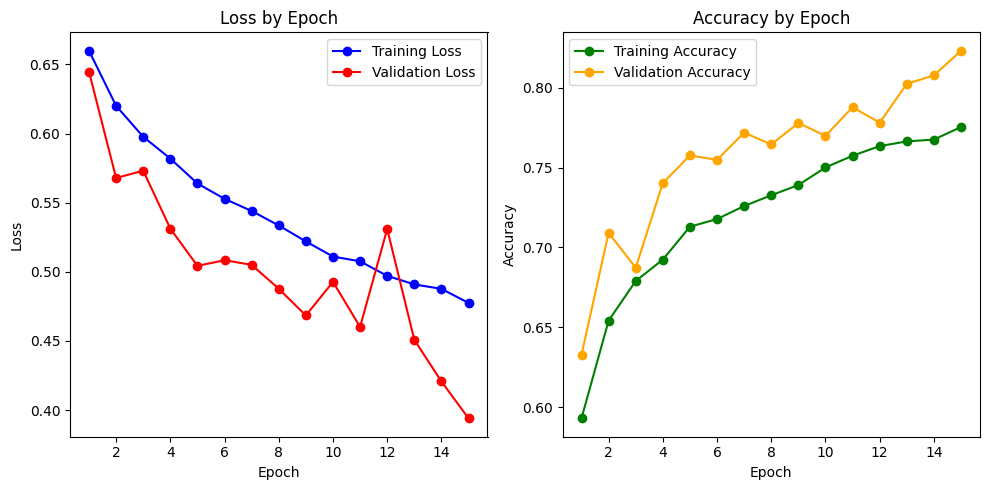

In [7]:
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 5)) 
# Plot Loss: Training vs. Validation
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], marker='o', color='blue', label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], marker='o', color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()

# Plot Accuracy: Training vs. Validation
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], marker='o', color='green', label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], marker='o', color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)


out = widgets.Output()
display(out)

def file_predict(filename, file_obj, out):
    """
    Loads an image from a file-like object, runs the prediction,
    and then displays the image with a title that includes the classification.
    """
    with out:
        print(f"Processing file: {filename}")
    try:
        # Get the image bytes from the BytesIO object.
        # Using getvalue() ensures we have a copy of the entire file content.
        img_bytes = file_obj.getvalue()
        
        # Load the image for prediction using a fresh BytesIO wrapper
        img = tf.keras.utils.load_img(BytesIO(img_bytes), target_size=(150, 150))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Run prediction (assuming your model variable is defined and loaded)
        prediction = model.predict(img_array, verbose=0)[0][0]
        
        # Decide the classification label based on the prediction value
        classification = "dog" if prediction > 0.5 else "cat"
        
        # Display the image along with a title that shows the classification result
        with out:
            display(HTML(f"<h3>{filename} is a {classification} ({prediction:.4f})</h3>"))
            display(IPImage(data=img_bytes))
            print("-" * 30)
    except Exception as e:
        with out:
            print(f"Error processing {filename}: {e}")

def on_upload_change(change):
    """Process uploaded files and run predictions."""
    with out:
        print("Upload change detected.")
        print("Change value:", change.new)
        
    items = change.new
    # Handle different data types (tuple, dict, or list) that uploader.value might be
    if isinstance(items, tuple):
        items = list(items)
    if isinstance(items, dict):
        for file_info in items.values():
            # Wrap the content in a BytesIO object and reset the pointer
            file_jpgdata = BytesIO(file_info['content'])
            file_jpgdata.seek(0)
            file_predict(file_info['name'], file_jpgdata, out)
    elif isinstance(items, list):
        for item in items:
            if isinstance(item, dict):
                file_jpgdata = BytesIO(item['content'])
                file_jpgdata.seek(0)
                file_predict(item['name'], file_jpgdata, out)
            else:
                file_jpgdata = BytesIO(item.content)
                file_jpgdata.seek(0)
                file_predict(item.name, file_jpgdata, out)

# Observe changes on the uploader widget so that on_upload_change gets called
uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()